In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from art.estimators.classification import PyTorchClassifier
import random 

from art.attacks import ExtractionAttack
from art.attacks.extraction import CopycatCNN, KnockoffNets
from torch.utils.data import random_split
import pandas as pd
import matplotlib.pyplot as plt
import art
from art.utils import load_mnist
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split


from CNN_Models import BaseCNN2D


random.seed(420)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


/home/fabian/GitHub/art_extraction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


## Prepare data

In [2]:
(x_train, y_train), (x_test0, y_test0), _, _ = load_mnist()

num_classes = 10
num_epochs = 100
learning_rate = 0.001
batch_size = 128
patience = 10  

x_train = torch.tensor(x_train, dtype=torch.float32).squeeze(-1)
y_train = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)
x_test0 = torch.tensor(x_test0, dtype=torch.float32).squeeze(-1)
y_test0 = torch.tensor(np.argmax(y_test0, axis=1), dtype=torch.long)

x_train = x_train.unsqueeze(1)
x_test0 = x_test0.unsqueeze(1)

train_dataset = TensorDataset(x_train, y_train)
test_dataset0 = TensorDataset(x_test0, y_test0)

validation_ratio = 0.1
total_train_samples = len(train_dataset)
validation_samples = int(total_train_samples * validation_ratio)
training_samples = total_train_samples - validation_samples

train_dataset, val_dataset = random_split(train_dataset, [training_samples, validation_samples])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader0 = DataLoader(test_dataset0, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

print(f'Samples in training dataset: {len(train_dataset)}')
print(f'Samples in validation dataset: {len(val_dataset)}')
print(f'Samples in test dataset: {len(test_dataset0)}')

Samples in training dataset: 54000
Samples in validation dataset: 6000
Samples in test dataset: 10000


## Train model

In [3]:
model = BaseCNN2D(num_classes=num_classes,device=device, num_epochs=5, learning_rate=learning_rate, patience=patience).to(device)
model.train_model(train_loader, val_loader)

Epoch [1/5], Loss: 0.2846, Accuracy: 91.29%
Epoch [2/5], Loss: 0.0942, Accuracy: 97.26%
Epoch [3/5], Loss: 0.0708, Accuracy: 97.91%
Epoch [4/5], Loss: 0.0568, Accuracy: 98.31%
Epoch [5/5], Loss: 0.0516, Accuracy: 98.41%
Validation at Epoch [5/5]: Loss: 0.0462, Accuracy: 98.47%


## Test model

In [4]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader0:
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 0.99%


## Define original Classifier

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer_original = optim.Adam(model.parameters(), lr=learning_rate)
classifier_original = PyTorchClassifier(model=model, loss=criterion, optimizer=optimizer_original, input_shape=(batch_size, x_train.shape[1], x_train.shape[2]), nb_classes=num_classes, device_type="gpu" if torch.cuda.is_available() else "cpu")

pred = classifier_original.predict(torch.FloatTensor(x_test0))

preds = np.argmax(pred, axis=1)
acc = np.mean(preds == y_test0.numpy())
print(f'Test Accuracy: {acc:.4f}')

Test Accuracy: 0.9907


## Run attacks

In [6]:

len_steal = 1000
attack_catalogue = {"Probabilistic CopycatCNN": CopycatCNN(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN": CopycatCNN(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets": KnockoffNets(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets": KnockoffNets(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                   }

results = []
percentages = [0.001, 0.005, 0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]

for percentage in percentages:
    len_steal = int(len(test_dataset0) * percentage)
    print(f"Running for len {len_steal}")
    num_steal_samples = int(len(test_dataset0) * percentage)
    steal_dataset, test_dataset = random_split(test_dataset0, [len(test_dataset0) - num_steal_samples, num_steal_samples])


    # Extract data and labels for steal and test sets
    x_steal, y_steal = [], []
    for data, label in steal_dataset:
        x_steal.append(data.numpy())
        y_steal.append(label.numpy())
    
    x_steal = np.array(x_steal)
    y_steal = np.array(y_steal)

    x_test, y_test = [], []
    for data, label in test_dataset:
        x_test.append(data.numpy())
        y_test.append(label.numpy())
    
    x_test = np.array(x_test)
    y_test = np.array(y_test)    
    
    # Perform attacks from the catalogue
    for name, attack in attack_catalogue.items():
        model_stolen = BaseCNN2D(num_classes=num_classes, device=device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model_stolen.parameters(), lr=learning_rate)
        
        classifier_stolen = PyTorchClassifier(
            model=model_stolen,
            loss=criterion,
            optimizer=optimizer,
            input_shape=(x_test.shape[1], x_test.shape[2], x_test.shape[3]),
            nb_classes=10,
            device_type="gpu" if torch.cuda.is_available() else "cpu",
        )       
        classifier_stolen = attack.extract(x_steal, y_steal, thieved_classifier=classifier_stolen)
        
        pred = classifier_stolen.predict(x_test)
        preds = np.argmax(pred, axis=1)
        acc = np.mean(preds == y_test)

        results.append((name, len_steal, acc))
        print(f"Attack: {name}, Steal Set Size: {len_steal}, Accuracy: {acc:.4f}")

Running for len 10
Attack: Probabilistic CopycatCNN, Steal Set Size: 10, Accuracy: 0.1000
Attack: Argmax CopycatCNN, Steal Set Size: 10, Accuracy: 0.9000
Attack: Probabilistic KnockoffNets, Steal Set Size: 10, Accuracy: 0.1000
Attack: Argmax KnockoffNets, Steal Set Size: 10, Accuracy: 0.9000
Running for len 50
Attack: Probabilistic CopycatCNN, Steal Set Size: 50, Accuracy: 0.0600
Attack: Argmax CopycatCNN, Steal Set Size: 50, Accuracy: 0.9800
Attack: Probabilistic KnockoffNets, Steal Set Size: 50, Accuracy: 0.0600
Attack: Argmax KnockoffNets, Steal Set Size: 50, Accuracy: 0.9800
Running for len 100
Attack: Probabilistic CopycatCNN, Steal Set Size: 100, Accuracy: 0.0800
Attack: Argmax CopycatCNN, Steal Set Size: 100, Accuracy: 0.9400
Attack: Probabilistic KnockoffNets, Steal Set Size: 100, Accuracy: 0.0800
Attack: Argmax KnockoffNets, Steal Set Size: 100, Accuracy: 0.9100
Running for len 500
Attack: Probabilistic CopycatCNN, Steal Set Size: 500, Accuracy: 0.1140
Attack: Argmax CopycatCN

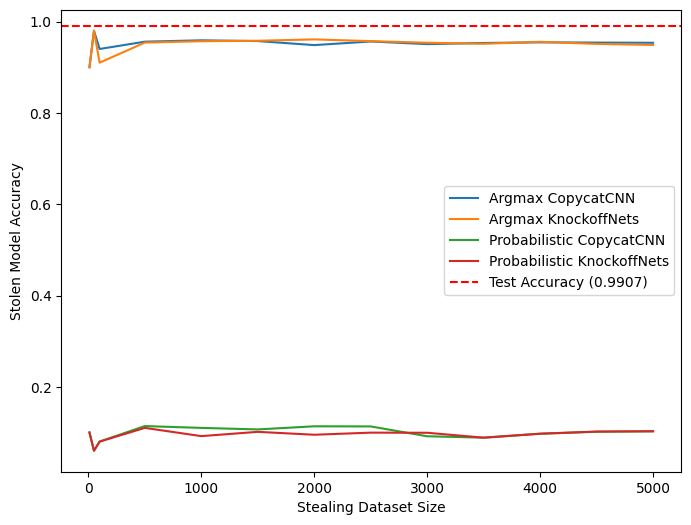

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(results, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
    
ax.axhline(y=accuracy, color='r', linestyle='--', 
            label=f"Test Accuracy ({accuracy:.4f})")
ax.legend()
plt.show()